# M6 Time Domain Metric Analysis

The M6 metric examines how often a survey region is revisited.  All science cases, by definition, require at least one visit to all HEALpixels in their desired survey region, while some indicate that multiple visits would be needed. The M6 metric calculates the area of a desired survey region to actually receive the requested number of visits in a survey strategy and compares this with the requested cadence. The result is expressed as a percentage of the requested visits, M6_%sky_area_nvisits.

Unlike the other metrics, this calculation is made separately for each region within a (science case, filter) or (survey design, filter) combination. This is because some cases request different cadence strategies for different sub-regions.

As a result, the metric output is quite complicated, and its best evaluated in smaller segments.

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [4]:
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

## M6 Sky area revisits - Time domain metric 

Given the many comparisions which can be made for this metric (in terms of science regions, survey regions, filters and survey elements), the results are most meaningful if we ask more specific questions. 

Given the RGPS survey as designed, only the time_domain fields provide meaningful time domain coverage, so we focus here on the results of evaluating the M6 metric for RGPS time domain fields, comparing them to the regions requested in community proposals categorize as time domain.  

In [5]:
# Load the M6 metric results for the high cadence field observations
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_nvisits_time_domain_results.txt')

m6_results = Table.read(m6_results_file, format='ascii')
m6_results

Survey_strategy,Survey_region,Science_case,Science_region,Common_area,Optic,M6_%sky_area_nvisits
str11,str31,str9,str27,float64,str4,float64
time_domain,time_domain_TDS_Baades_Windows,Paladini2,Paladini2_Paladini2,0.0,F213,0.0
time_domain,time_domain_TDS_Galactic_Center,Paladini2,Paladini2_Paladini2,0.0,F213,0.0
time_domain,time_domain_TDS_NGC6334_6357,Paladini2,Paladini2_Paladini2,0.0,F213,0.0
time_domain,time_domain_TDS_Carina,Paladini2,Paladini2_Paladini2,0.0,F213,0.0
time_domain,time_domain_TDS_Serpens_W40,Paladini2,Paladini2_Paladini2,18.464460194645667,F213,48.88888888888888
time_domain,time_domain,Benecchi,Benecchi_Benecchi1,0.0,F146,0.0
time_domain,time_domain_TDS_Baades_Windows,Kupfer,Kupfer_NGC6528,0.0,F062,0.0
time_domain,time_domain_TDS_Galactic_Center,Kupfer,Kupfer_NGC6528,0.0,F062,0.0
time_domain,time_domain_TDS_NGC6334_6357,Kupfer,Kupfer_NGC6528,0.0,F062,0.0


We'd like to know which of the requested regions receives coverage.  The discrete nature of the time domain fields means that it only makes sense to consider the survey fields that overlap the requested region. 

Bahramian_XRB1
Survey_strategy          Survey_region          Science_case Science_region    Common_area     Optic M6_%sky_area_nvisits
--------------- ------------------------------- ------------ -------------- ------------------ ----- --------------------
    time_domain  time_domain_TDS_Baades_Windows    Bahramian Bahramian_XRB1  6.714349161689334  F087  0.14847809948032664
    time_domain time_domain_TDS_Galactic_Center    Bahramian Bahramian_XRB1  7.553642806900501  F087  0.16703786191536749
    time_domain    time_domain_TDS_NGC6334_6357    Bahramian Bahramian_XRB1  7.553642806900501  F087  0.16703786191536749
    time_domain          time_domain_TDS_Carina    Bahramian Bahramian_XRB1  7.553642806900501  F087  0.16703786191536749
    time_domain             time_domain_TDS_W43    Bahramian Bahramian_XRB1  6.714349161689334  F087  0.14847809948032664
    time_domain  time_domain_TDS_Baades_Windows    Bahramian Bahramian_XRB1  6.714349161689334  F129  0.14847809948032664
    time_

NameError: name 'bar_width' is not defined

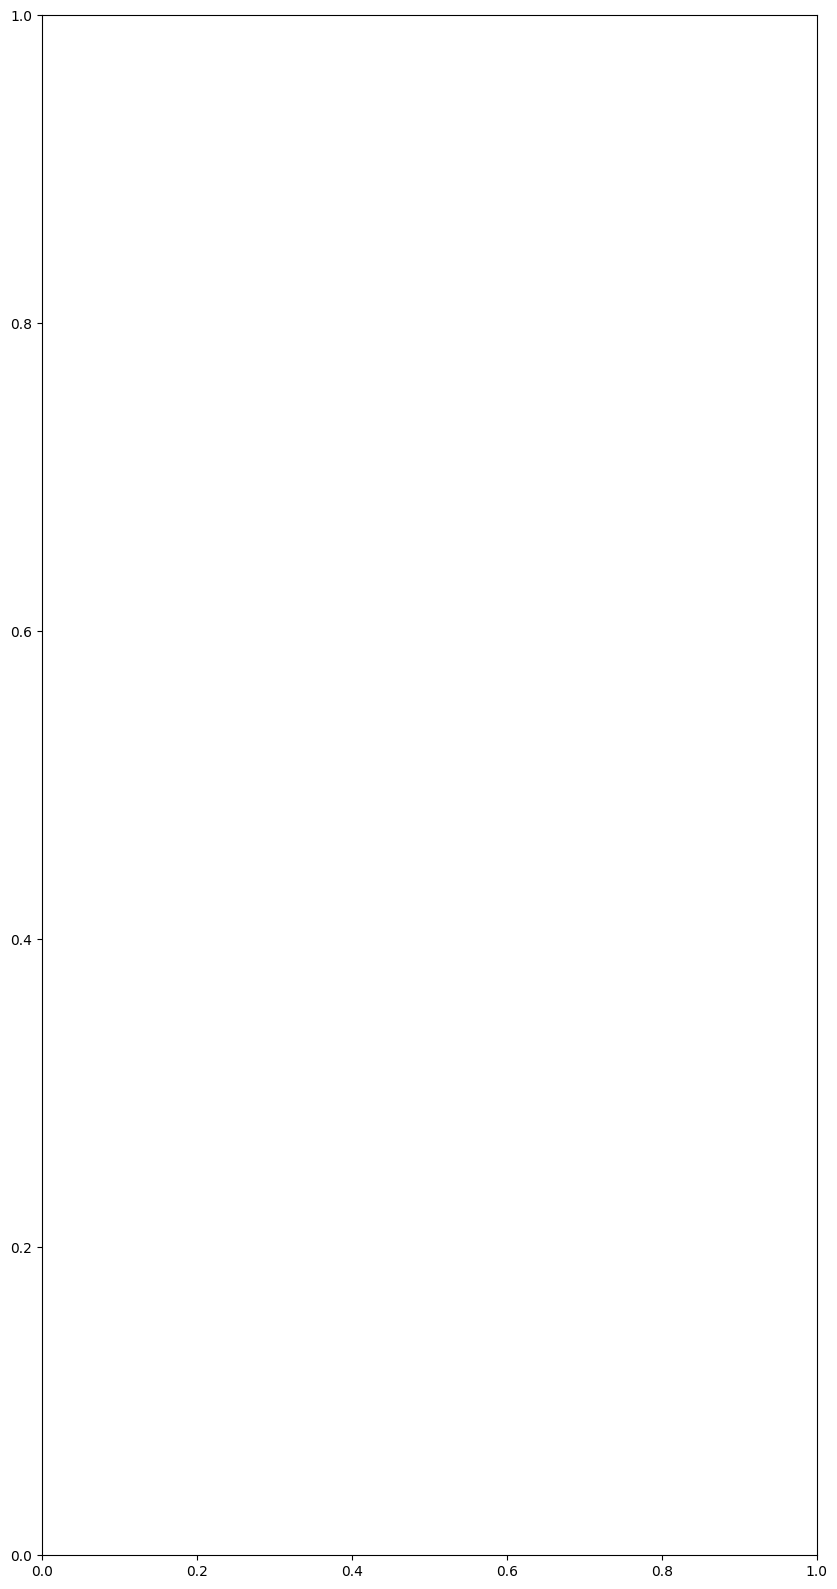

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,20))

# List the individual survey regions for each survey design
survey_regions = list(set(m6_results['Survey_region'].data))
survey_regions.sort()

# Similarly, list the regions from the science case
science_regions = list(set(m6_results['Science_region'].data))
science_regions.sort()

for iscience, rscience in enumerate(science_regions):
    jdx = np.where(m6_results['Science_region'] == rscience)[0]
    metric_filter = m6_results[jdx]
    print(rscience)
    metric_filter.pprint_all()
    breakpoint()
    
    # Metric results are only listed for the filter(s) requested by the science case.  
    # Identify which if any survey regions overlapped with this science region 
    kdx = np.where(metric_filter['Common_area'] > 0.0)[0]
    print(kdx)
    if len(kdx) > 0:
        for row in kdx:
            data = [
                    iscience, 
                    metric_filter['Common_area'][kdx][0], 
                    metric_filter['M6_%sky_area_nvisits'][kdx][0], 
                    metric_filter['Optic'][kdx][0]
                ]
            ax.barh(
            data[0], data[2], bar_width,
                color=sim_config['PLOT_COLORS'][data[3]], alpha=0.75,
            )

    
plt.tight_layout()
#plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm6_results_sky_area_nvisits_'+case+'_'+optic+'.png'))
#plt.close()